# Reproduce Results notebook
+ Here the results have to be shown without David having to wait 1h 30mins til the model trains.

# To Do:
+ Pickle of the HMM model (Done - Jordi)
+ Fix the HiddenMarkovModel.py so the HMM code called from there
+ Implement the Edit_dist for the closes word to work in the test
+ Check the results for the extended_feature
+ Pickle of BERT

# Sctructure:
+ Read data
+ Spell checker
+ HMM
+ Id fetures
+ Structured Perceptron (Notebook: Structured_Perceptron_Validation)
+ BERT

In [1]:
# !pip3 install editdistance
# !pip3 install nltk

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

import editdistance
import itertools
import seaborn as sn

from HiddenMarkovModel import *

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

In [4]:
# Using ffill we optimize the code. It will fill all missing values with the previous non-nan value
data = pd.read_csv("../data/kaggle_ner/ner_dataset.csv",
                   encoding="latin1").fillna(method="ffill")

In [5]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
print("Available TAGS:")
print(set(data["Tag"]))

Available TAGS:
{'I-tim', 'I-eve', 'I-gpe', 'I-geo', 'O', 'B-org', 'I-org', 'B-gpe', 'B-tim', 'I-art', 'I-per', 'B-eve', 'I-nat', 'B-geo', 'B-nat', 'B-per', 'B-art'}


In [7]:
print("{:10s} | {:20s}".format("TAG", "Examples"))
print("-"*60)
for tag in set(data["Tag"]):
    print("{:10s} | {:20s} {:20s} {:20s}".format(tag, *data[data["Tag"] == tag]["Word"][0:3].values))

TAG        | Examples            
------------------------------------------------------------
I-tim      | 8                    1                    2                   
I-eve      | Summer               Olympics             Olympic             
I-gpe      | States               Korea                Binh                
I-geo      | Park                 State                State               
O          | Thousands            of                   demonstrators       
B-org      | Labor                International        IAEA                
I-org      | Party                Atomic               Energy              
B-gpe      | British              English              Britain             
B-tim      | Wednesday            Wednesday            Tuesday             
I-art      | Non-Proliferation    V-6                  Simple              
I-per      | Mahmoud              Ahmadinejad          Horbach             
B-eve      | 2012                 Games                Games         

#### Using groupby and apply rather than a for loop the computation is reduced from +2h to 4s

In [8]:
%time X_txt = list(data.groupby("Sentence #")['Word'].apply(list))
%time Y_txt = list(data.groupby("Sentence #")['Tag'].apply(list))

CPU times: user 3.96 s, sys: 4 ms, total: 3.96 s
Wall time: 3.95 s
CPU times: user 4.16 s, sys: 4 ms, total: 4.17 s
Wall time: 4.15 s


In [9]:
i = 0
xy = ["{}/{}".format(x,y) for x,y in zip(X_txt[i],Y_txt[i])]
" ".join(xy)

'Thousands/O of/O demonstrators/O have/O marched/O through/O London/B-geo to/O protest/O the/O war/O in/O Iraq/B-geo and/O demand/O the/O withdrawal/O of/O British/B-gpe troops/O from/O that/O country/O ./O'

In [10]:
print("There are", len(data["Word"].unique()), "words in the dictionary.")
print("And", len(data['Sentence #'].unique()), "unique sentences.")

There are 35178 words in the dictionary.
And 47959 unique sentences.


## Word to pos and tag to pos

In [11]:
def build_word_to_pos(X):
    word_to_pos = {k: i for i, k in enumerate(X['Word'].unique())}               
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {k: i for i, k in enumerate(Y['Tag'].unique())} 
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag

In [12]:
word_to_pos, pos_to_word = build_word_to_pos(data)
tag_to_pos, pos_to_tag  = build_tag_to_pos(data)

len(word_to_pos), len(tag_to_pos)

(35178, 17)

In [13]:
X = [[word_to_pos[w] for w in s] for s in X_txt]
Y = [[tag_to_pos[t] for t in s] for s in Y_txt]

# Preparing the dataset

In [14]:
import scipy
import numpy as np
import os,sys,inspect
import skseq

In [15]:
import skseq.sequences
import skseq.readers

from skseq.sequences import sequence
from skseq.sequences import sequence_list
from skseq.sequences import label_dictionary

In [16]:
n_split = 35971
X_train_txt, X_test_txt, Y_train_txt, Y_test_txt = X_txt[:n_split], X_txt[n_split:], Y_txt[:n_split], Y_txt[n_split:]

In [17]:
TEST_SENTENCES = ["The programmers from Barcelona might write a sentence without a spell checker.",
"The programmers from Barchelona cannot write a sentence without a spell checker.",
"Jack London went to Parrris.",
"Jack London went to Paris.",
"We never though Microsoft would become such a big company.",
"We never though Microsof would become such a big company.",
"The president of U.S.A though they could win the war",
"The president of the United States of America though they could win the war",
"The king of Saudi Arabia wanted total control.",
"Robin does not want to go to Saudi Arabia.",
"Apple is a great company.",
"I really love apples and oranges."]

# HMM

In [23]:
import pickle
hmm = pickle.load(open("HMM.pkl", "rb" ))

In [24]:
def evaluate_hmm(dataset_X, dataset_Y, tags):
    tot = 0
    err = 0
    matrix = np.zeros((len(tags), len(tags)))

    mstks = []
    correct = []

    tbar = tqdm(dataset_X)
    for i, xtest in enumerate(tbar):
        pred = hmm.predict_labels(xtest) # With posterior decoding
        yral = dataset_Y[i]
        
        for pred_tag, yral_tag in zip(pred, yral):
            row, col = np.where(tags == pred_tag)[0][0], np.where(tags == yral_tag)[0][0]
            matrix[row, col] += 1

        s = sum(v1!=v2 for v1,v2 in list(zip(pred, yral)))
        err+= s
        tot+=len(yral)

        toappend = mstks if s!=0 else correct
        toappend.append(pd.DataFrame([xtest, pred, yral]))
        if i%100==0:
            tbar.set_description("Accuracy: {:6.4f}".format(1-err/tot))
    return correct, mstks, matrix

In [25]:
to_evaluate = 500 # 0 for all

X_tr_ev, X_te_ev = (X_train_txt[:to_evaluate], X_test_txt[:to_evaluate]) if to_evaluate > 0 else (X_train_txt, X_test_txt)

tags = data["Tag"].unique()
train_correct, train_mstks, train_conf = evaluate_hmm(X_tr_ev, Y_train_txt, tags)
test_correct, test_mstks, test_conf = evaluate_hmm(X_te_ev, Y_test_txt, tags)

/notebooks/NameEntityRecognition/gitproject/deliverable_2/AlbertGarcia_PereGilabert_MikeDePass_JordiSole_AlejandroGonzalez/HiddenMarkovModel.py:234: RuntimeWarning: invalid value encountered in subtract
  state_posteriors[:, pos] = log_f_x[:, pos] + log_b_x[:, pos] - log_likelihood


In [27]:
print('Number of correct sequences from both train and test:', len(train_correct)+len(test_correct))

Number of correct sequences from both train and test: 579


#### Train accuracy of 97.24%
#### Test accuracy of 92.49%
#### Total correctly predicted sequences 30,424

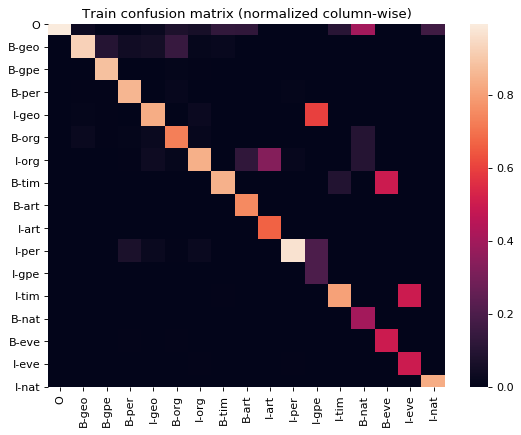

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


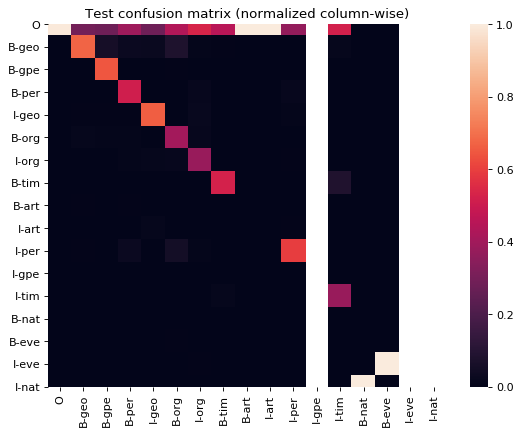

In [28]:
from matplotlib.pyplot import figure

normalized_train_conf = train_conf / np.sum(train_conf, axis=0)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sn.heatmap(normalized_train_conf, annot=False, xticklabels=tags, yticklabels=tags).set_title("Train confusion matrix (normalized column-wise)")
plt.show()

normalized_test_conf = test_conf / np.sum(test_conf, axis=0)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sn.heatmap(normalized_test_conf, annot=False, xticklabels=tags, yticklabels=tags).set_title("Test confusion matrix (normalized column-wise)")
plt.show()

The columns correspond to ground truth tags and the rows to the predicted tags. Both confusion matrices have been normalized column-wise (with respect ot the ground truth of the dataset) since there are several outliers when not normalizing the values (plotting with the count values). Notice how in the test set a lot of tags have been incorrectly predicted as 'O'. From this we can say that HMM tends to predict 'O' in cases it should not. This could be done due to the way HMM is trained and due to the huge imbalanced tags (the number of words with tag 'O' is way larger than any other tag).

In [29]:
# test_mstks[0]

Row 1 is the predicted sequence while row 2 is the ground truth sequence. By looking at a misclassified sample we can also see how there have been lots of 'O' predictions that should not have been predicted as such.

In [49]:
for sentence in TEST_SENTENCES:
    splited = sentence.split()
    splited = splited[:-1] + [splited[-1]] if splited[-1]=='.' else splited
    pred = hmm.predict_labels(splited)
    df = pd.DataFrame([splited, pred])
    display(df.style)

/notebooks/NameEntityRecognition/gitproject/deliverable_2/AlbertGarcia_PereGilabert_MikeDePass_JordiSole_AlejandroGonzalez/HiddenMarkovModel.py:244: RuntimeWarning: invalid value encountered in subtract
  for pos in range(len(x)):


,0,1,2,3,4,5,6,7,8,9,10,11
0,The,programmers,from,Barcelona,might,write,a,sentence,without,a,spell,checker.
1,O,O,O,O,O,O,O,O,O,O,O,O


,0,1,2,3,4,5,6,7,8,9,10,11
0,The,programmers,from,Barchelona,cannot,write,a,sentence,without,a,spell,checker.
1,O,O,O,O,O,O,O,O,O,O,O,O


,0,1,2,3,4
0,Jack,London,went,to,Parrris.
1,O,O,O,O,O


,0,1,2,3,4
0,Jack,London,went,to,Paris.
1,O,O,O,O,O


,0,1,2,3,4,5,6,7,8,9
0,We,never,though,Microsoft,would,become,such,a,big,company.
1,O,O,O,O,O,O,O,O,O,O


,0,1,2,3,4,5,6,7,8,9
0,We,never,though,Microsof,would,become,such,a,big,company.
1,O,O,O,O,O,O,O,O,O,O


,0,1,2,3,4,5,6,7,8,9
0,The,president,of,U.S.A,though,they,could,win,the,war
1,O,O,O,B-org,O,O,O,O,O,O


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,The,president,of,the,United,States,of,America,though,they,could,win,the,war
1,O,O,O,O,B-geo,I-geo,I-geo,I-geo,O,O,O,O,O,O


,0,1,2,3,4,5,6,7
0,The,king,of,Saudi,Arabia,wanted,total,control.
1,O,O,O,O,O,O,O,O


,0,1,2,3,4,5,6,7,8
0,Robin,does,not,want,to,go,to,Saudi,Arabia.
1,O,O,O,O,O,O,O,O,O


,0,1,2,3,4
0,Apple,is,a,great,company.
1,O,O,O,O,O


,0,1,2,3,4,5
0,I,really,love,apples,and,oranges.
1,O,O,O,O,O,O


# Structured perceptron

In [19]:
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.sequence import Sequence
from skseq.sequences.label_dictionary import LabelDictionary

x_dict = LabelDictionary(label_names=data['Word'].unique())
y_dict = LabelDictionary(label_names=data['Tag'].unique())

train_seq_list = SequenceList(x_dict, y_dict)
for x,y in zip(X_train_txt, Y_train_txt):
    train_seq_list.add_sequence(x, y, x_dict, y_dict)

test_seq_list = SequenceList(x_dict, y_dict)
for x,y in zip(X_test_txt, Y_test_txt):
    test_seq_list.add_sequence(x, y, x_dict, y_dict)

In [20]:
class BK_Tree():    
    def __init__(self, documents):
        self.root = Node(documents[0][0])
        for seq in documents:
            for word in seq:
                self.root.append(word)
        
    def append(self, word):
        self.root.append(word)
        
    def is_in_corpus(self, new_word):
        return self.root.is_in_corpus(new_word)
        
        
class Node():    
    def __init__(self, word):
        self.word = word
        self.dict_dist = {}
    
    def is_in_corpus(self, new_word):
        if self.word == new_word:
            return True
        dist = editdistance.eval(self.word, new_word)
        if dist not in self.dict_dist:
            return False
        return self.dict_dist[dist].is_in_corpus(new_word)
    
    def append(self, new_word):
        dist = editdistance.eval(self.word, new_word)
        if dist not in self.dict_dist:
            if self.word!=new_word:
                self.dict_dist[dist] = Node(new_word)
        else:
            self.dict_dist[dist].append(new_word)    
            
            
def edit_ditance_word(mistake, X_train_txt):
    # mistake = "Barchelona" 
    corpus = [w for seq in X_train_txt for w in seq]
    distances = [editdistance.eval(mistake, word) for word in corpus]
    return corpus[np.argmin(distances)], min(distances)

In [21]:
# You can improve the results adding more features

# from skseq.sequences import extended_feature
# feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq_list)

In [22]:
feature_mapper = skseq.sequences.id_feature.IDFeatures(train_seq_list)
feature_mapper.build_features()

print('Feature dict length:', len(feature_mapper.feature_dict))
print('Feature list length:', len(feature_mapper.feature_list))

import skseq.sequences.structured_perceptron_validation as spc
# sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp = spc.StructuredPerceptronValidation(x_dict, y_dict, feature_mapper, averaged=False)


def train_perceptron(load_no_fit = True, num_epochs = 50, epochs_before_stopping = 5, dir_to_params = './'):
    if not load_no_fit:
        print('Training for %i epochs with early stopping after %i epochs of no improvement' % (num_epochs, epochs_before_stopping))
#         %time sp.fit(dummy_seq_list, val_seq_list, num_epochs, epochs_before_stopping, dir_to_params)
        %time sp.fit(train_seq_list, test_seq_list, num_epochs, epochs_before_stopping, dir_to_params)
    else:
        sp.load_model(dir_to_params)
        
        
import pandas as pd
from IPython.core import display as ICD


Feature dict length: 38298
Feature list length: 35971


In [23]:
def evaluate_corpus(sequences, sequences_predictions):
    total = 0.0
    correct = 0.0
    num_correct_sequences = 0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        whole_prediction_correct = True
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                correct += 1
            else:
                whole_prediction_correct = False
            total += 1
        if whole_prediction_correct: num_correct_sequences += 1
    return correct / total, num_correct_sequences

def evaluate_perceptron():
    # Make predictions for the various sequences using the trained model.
    pred_train = sp.viterbi_decode_corpus(train_seq_list)
    pred_test  = sp.viterbi_decode_corpus(test_seq_list)

    # Evaluate and print accuracies
    eval_train, num_correct_train = evaluate_corpus(train_seq_list.seq_list, pred_train)
    eval_test, num_correct_test = evaluate_corpus(test_seq_list.seq_list, pred_test)

    print("SP -  Accuracy Train: %.3f Test: %.3f"%(eval_train, eval_test))
    
    print('Correctly predicted sequences in Train:', num_correct_train)
    print('Correctly predicted sequences in Test:', num_correct_test)
    print('Total correctly predicted sequences:', num_correct_train+num_correct_test)
    
    return pred_train, pred_test
    
def predict_text_tags(seq, nice_format=False, change_word=False, sensibility=2):
    assert isinstance(seq, str) or isinstance(seq, list), "The input must be a sentence (string format or a list of words)"
    corpus = list(itertools.chain(*X_train_txt)) ###
    
    if isinstance(seq, str):
        seq = seq.split()      
    
    num2lab = {v:k for k,v in sp.state_labels.items()}
    if nice_format:
        grp = pd.DataFrame([seq, [num2lab[w] for w in sp.predict_tags_given_words(seq)]], 
                           index=["Words", "Tags"], columns=["W_{:02d}".format(i) for i in range(len(seq))])   
        grp = grp.style.applymap(lambda x: 'color: blue' if x != 'O' and x in sp.state_labels else 'color: black')
        ICD.display(grp)
        
    else:
        res = ""
        for o, w in zip(seq, sp.predict_tags_given_words(seq)):
            if o not in corpus:                                         ###
                correct_o, dist = edit_ditance_word(o, X_train_txt)
                if dist <= sensibility:
                    seq[seq.index(o)] = correct_o
                    w = sp.predict_tags_given_words(seq)[seq.index(correct_o)]
                    if change_word:
                        o = correct_o
            ft = " {}/{}" if num2lab[w]=='O' else " {}/\x1b[34m{}\x1b[0m"
            res += ft.format(o, num2lab[w]) 
        print(res)
    
    
def predict_batch_text_tags(batch, nice_format=False, change_word=False, sensibility=2):
    all_s = sum(isinstance(seq, str) for seq in batch)
    all_l = sum(isinstance(seq, list) for seq in batch)
    assert all_s==0 or all_l==0, "The inputs must be sentences (string format or lists of words)"

    for b in batch:
        predict_text_tags(b, nice_format, change_word, sensibility)
        
        
def word_in_corpus(phrase):
    corpus = list(itertools.chain(*X_train_txt)) # Use train words
    for i in range(len(phrase)):
        if phrase[i] not in corpus:
            print(phrase[i])
            palabra, dist = edit_ditance_word(phrase[i])
            if dist==1:
                phrase[i] = palabra
    return phrase


def edit_ditance_word(mistake, X_train_txt):
    # mistake = "Barchelona" 
    corpus = [w for seq in X_train_txt for w in seq]
    distances = [editdistance.eval(mistake, word) for word in corpus]
    return corpus[np.argmin(distances)], min(distances)

In [24]:
train_perceptron(load_no_fit=True)

In [25]:
pred_train, pred_test = evaluate_perceptron()

tags = list(map(lambda x: sp.state_labels[x], data["Tag"].unique()))

train_conf = np.zeros((len(tags), len(tags)))
for train_pred, train_true in zip(pred_train, train_seq_list.seq_list):
    for i in range(len(train_true.y)):
        train_conf[train_pred.y[i], train_true.y[i]] += 1

test_conf = np.zeros((len(tags), len(tags)))
for test_pred, test_true in zip(pred_test, test_seq_list.seq_list):
    for i in range(len(test_true.y)):
        test_conf[test_pred.y[i], test_true.y[i]] += 1

SP -  Accuracy Train: 0.969 Test: 0.955
Correctly predicted sequences in Train: 23244
Correctly predicted sequences in Test: 6602
Total correctly predicted sequences: 29846


#### Train accuracy of 96.90%
#### Test accuracy of 95.50%
#### Total correctly predicted sequences: 29,846

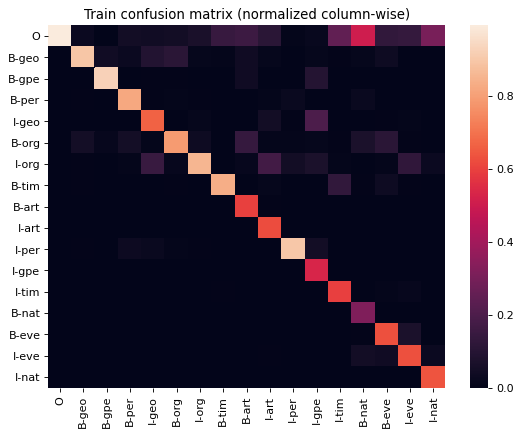

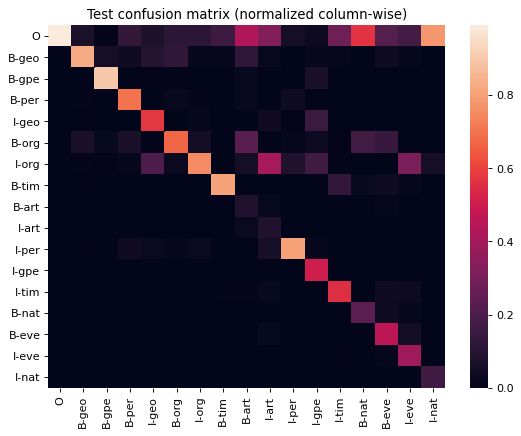

In [53]:
from matplotlib.pyplot import figure
num2label = {v:k for k,v in sp.state_labels.items()}

normalized_train_conf = train_conf / np.sum(train_conf, axis=0)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sn.heatmap(normalized_train_conf, annot=False, xticklabels=list(map(lambda x: num2label[x], tags)), yticklabels=list(map(lambda x: num2label[x], tags))).set_title("Train confusion matrix (normalized column-wise)")
plt.show()

normalized_test_conf = test_conf / np.sum(test_conf, axis=0)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sn.heatmap(normalized_test_conf, annot=False, xticklabels=list(map(lambda x: num2label[x], tags)), yticklabels=list(map(lambda x: num2label[x], tags))).set_title("Test confusion matrix (normalized column-wise)")
plt.show()

The columns correspond to ground truth tags and the rows to the predicted tags. Both confusion matrices have been normalized column-wise (with respect ot the ground truth of the dataset) since there are several outliers when not normalizing the values (plotting with the count values). Compared to the HMM model, the test confusion matrix no longer shows a large amount of incorrectly classified 'O' tags. The tags 'I-art' and 'B-art' are still not correctly identified (in both HMM and SP). We can also detect some tags in which there is some confusion with the tag 'O' like the tags 'B-nat' and 'I-nat'. Additionally, the pairs of tags 'I-art'-'I-org' as well as the pair 'I-eve'-'I-org' are confused to some extent.

In [62]:
predict_batch_text_tags(TEST_SENTENCES, nice_format=False, change_word=False, sensibility=2)

 The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O
 The/O programmers/O from/O Barchelona/B-geo cannot/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O
 Jack/B-per London/I-per went/O to/O Parrris/B-geo ./O
 Jack/B-per London/I-per went/O to/O Paris/B-geo ./O
 We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O
 We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company/O ./O
 The/O president/O of/O U.S.A/B-org though/O they/O could/O win/O the/O war/O
 The/O president/O of/O the/O United/B-geo States/I-geo of/O America/B-geo though/O they/O could/O win/O the/O war/O
 The/O king/O of/O Saudi/B-org Arabia/I-org wanted/O total/O control/O ./O
 Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-org Arabia/I-org ./O
 Apple/B-org is/O a/O great/O company/O ./O
 I/O really/O love/O apples/O and/O oranges/O ./O


Overall the TEST_SENTENCES have been all corectly tagged except for some specific words like the 'Robin' word being tagged as 'O'.

# BERT
+ Bidirectional Encoder Representations from Transformers

In [291]:
import pickle
tag2idx = pickle.load(open('bert_tag2idx.pkl', 'rb'))

In [292]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences

In [293]:
MAX_LEN = 75
bs = 32

In [322]:
# GPU 
gpu_id = 1

device = torch.device("cuda:{}".format(gpu_id) if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(gpu_id)

'GeForce RTX 2080 Ti'

In [323]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [324]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [325]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in tqdm(zip(X_test_txt, Y_test_txt), total=len(X_test_txt))]

In [326]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [327]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [328]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [329]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [330]:
inputs = torch.tensor(input_ids)
tags = torch.tensor(tags)
masks = torch.tensor(attention_masks)

In [331]:
eval_data = TensorDataset(inputs, masks, tags)
eval_sampler = RandomSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=bs)

In [332]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [333]:
bert_model_to_load = "BERT_ep_4_acc_0.9611.pt"

In [334]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False,
    state_dict = torch.load(bert_model_to_load)
)
model.to(device=device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Test set

In [335]:
from seqeval.metrics import f1_score, accuracy_score

In [336]:
eval_loss = 0
predictions = []
true_labels = []
for batch in tqdm(eval_dataloader, desc="Validation", leave=False):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

In [310]:
idx2tag = {v: k for k,v in tag2idx.items()}

In [313]:
pred_tags = [idx2tag[p_i] for p, l in zip(predictions, true_labels)
                             for p_i, l_i in zip(p, l) if idx2tag[l_i] != "PAD"]
valid_tags = [idx2tag[l_i] for l in true_labels
                              for l_i in l if idx2tag[l_i] != "PAD"]

In [314]:
print("Accuracy on test set: {:5.5f}".format(accuracy_score(pred_tags, valid_tags)))

Accuracy on test set: 0.96108


### Confusion matrix

In [315]:
cnf_matrix = confusion_matrix(valid_tags, pred_tags, labels=list(tag2idx.keys())[:-1], )
cnf_matrix_norm = cnf_matrix/np.sum(cnf_matrix, axis=0).astype(np.float32)

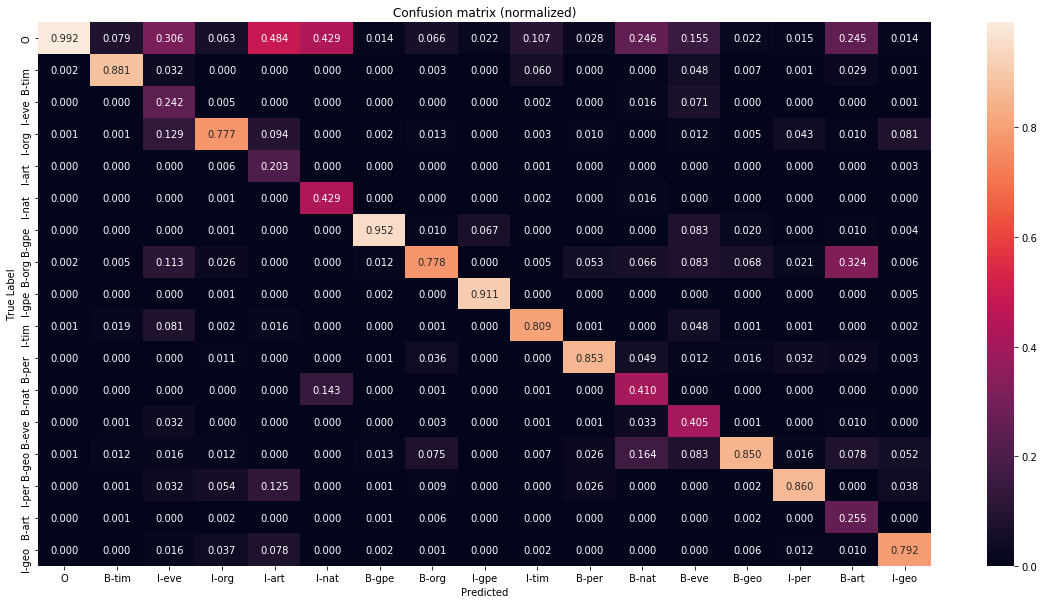

In [337]:
plt.figure(figsize=(20,10))
# cnf_matrix = confusion_matrix(valid_tags, pred_tags, labels=list(tag2idx.keys())[:-1], )
df_cm = pd.DataFrame(cnf_matrix_norm, columns=list(tag2idx.keys())[:-1], index=list(tag2idx.keys())[:-1])
sn.heatmap(df_cm, annot=True, fmt='.3f')
b,t = plt.ylim()
plt.ylim(b+0.5, t-0.5)
plt.title("Confusion matrix (normalized)")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()

### Test sentences

In [321]:
for test_sentence in TEST_SENTENCES:
    tokenized_sentence = tokenizer.encode(test_sentence)
    input_ids = torch.tensor([tokenized_sentence]).to(device=device)

    with torch.no_grad():
        output = model(input_ids)
    
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)[0][1:-1]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])[1:-1]
    
    # Merge tokens starting with ##
    new_tokens, new_labels = [], []    
    for token, label_idx in zip(tokens, label_indices):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(idx2tag[label_idx])
            new_tokens.append(token)
            
    for token, label in zip(new_tokens, new_labels):
        if label=='O':
            print("{}\{}".format(token, label), end=" ")
        else:
            print("{}\x1b[34m\\{}\x1b[0m".format(token, label), end=" ")
    print()

The\O programmers\O from\O Barcelona\B-geo might\O write\O a\O sentence\O without\O a\O spell\O checker\O .\O 
The\O programmers\O from\O Barchelona\B-geo cannot\O write\O a\O sentence\O without\O a\O spell\O checker\O .\O 
Jack\B-per London\I-per went\O to\O Parrris\B-geo .\O 
Jack\B-per London\I-per went\O to\O Paris\B-geo .\O 
We\O never\O though\O Microsoft\B-org would\O become\O such\O a\O big\O company\O .\O 
We\O never\O though\O Microsof\B-org would\O become\O such\O a\O big\O company\O .\O 
The\O president\O of\O U\B-org .\B-org S\B-org .\B-org A\B-org though\O they\O could\O win\O the\O war\O 
The\O president\O of\O the\O United\B-geo States\I-geo of\I-geo America\I-geo though\O they\O could\O win\O the\O war\O 
The\O king\O of\O Saudi\B-geo Arabia\I-org wanted\O total\O control\O .\O 
Robin\B-per does\O not\O want\O to\O go\O to\O Saudi\B-geo Arabia\I-geo .\O 
Apple\B-org is\O a\O great\O company\O .\O 
I\O really\O love\O apples\O and\O oranges\O .\O 
